# Imports

In [228]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import numpy as np

# Constants

In [231]:
VOCAB_SIZE = 5   # {PAD, 0, 1, SEP, EOS}
PAD, ZERO, ONE, SEP, EOS = range(5)
MAX_LEN = 10
DEVICE = "cpu"

torch.manual_seed(42)

# Data

In [234]:
def generate_batch(batch_size=32):
    a = torch.randint(0, 2, (batch_size, MAX_LEN//2))
    b = torch.randint(0, 2, (batch_size, MAX_LEN//2))

    src = torch.cat([
        a + 1,                      # shift 0/1 → 1/2
        torch.full((batch_size, 1), SEP),
        b + 1
    ], dim=1)

    tgt = []
    for ai, bi in zip(a, b):
        x = int("".join(map(str, ai.tolist())), 2)
        y = int("".join(map(str, bi.tolist())), 2)
        s = bin(x + y)[2:]
        tgt.append([int(c) + 1 for c in s] + [EOS])

    tgt = torch.nn.utils.rnn.pad_sequence(
        [torch.tensor(t) for t in tgt],
        batch_first=True,
        padding_value=PAD
    )

    return src, tgt


# Positional Encoding

In [237]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x):
        return x + self.pe[:x.size(1)]


# Attention

In [240]:
def scaled_dot_product_attention(Q, K, V, mask=None, return_attn=False):
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)

    if mask is not None:
        scores = scores.masked_fill(mask == 0, float("-inf"))

    attn = torch.softmax(scores, dim=-1)
    output = torch.matmul(attn, V)

    if return_attn:
        return output, attn
    return output

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.last_attn = None

    def split_heads(self, x):
        batch, seq, _ = x.size()
        x = x.view(batch, seq, self.num_heads, self.d_k)
        return x.transpose(1, 2)

    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        out, attn = scaled_dot_product_attention(Q, K, V, mask, return_attn=True)
        self.last_attn = attn.detach()

        out = out.transpose(1, 2).contiguous()
        batch, seq_len, _, _ = out.size()
        out = out.view(batch, seq_len, self.num_heads * self.d_k)

        return self.W_o(out)


# Feed Forward

In [243]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(torch.relu(self.linear1(x)))

# Encoder / Decoder Layers

In [246]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x, mask):
        x = self.norm1(x + self.attn(x, x, x, mask))
        x = self.norm2(x + self.ffn(x))
        return x

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForward(d_model, d_ff)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

    def forward(self, x, enc_out, src_mask, tgt_mask):
        x = self.norm1(x + self.self_attn(x, x, x, tgt_mask))
        x = self.norm2(x + self.enc_attn(x, enc_out, enc_out, src_mask))
        x = self.norm3(x + self.ffn(x))
        return x


# Transformer

In [249]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model=128, num_heads=4, d_ff=512, N=2):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos = PositionalEncoding(d_model)

        self.encoder = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff) for _ in range(N)
        ])
        self.decoder = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff) for _ in range(N)
        ])

        self.out = nn.Linear(d_model, vocab_size)

    def forward(self, src, tgt, src_mask, tgt_mask):
        src = self.pos(self.embed(src))
        tgt = self.pos(self.embed(tgt))

        for layer in self.encoder:
            src = layer(src, src_mask)

        for layer in self.decoder:
            tgt = layer(tgt, src, src_mask, tgt_mask)

        return self.out(tgt)


# Masks

In [252]:
def subsequent_mask(size):
    mask = torch.tril(torch.ones(size, size)).bool()
    return mask.unsqueeze(0).unsqueeze(1)

# Training

In [190]:
model = Transformer(VOCAB_SIZE).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-9)
criterion = nn.CrossEntropyLoss(ignore_index=PAD)

loss_history = []

print("🚀 Starting training...\n")

for step in range(1, 2001):
    src, tgt = generate_batch()
    tgt_in = tgt[:, :-1]
    tgt_out = tgt[:, 1:]

    src_mask = (src != PAD).unsqueeze(1).unsqueeze(2)
    tgt_mask = subsequent_mask(tgt_in.size(1))

    logits = model(src, tgt_in, src_mask, tgt_mask)
    loss = criterion(logits.reshape(-1, VOCAB_SIZE), tgt_out.reshape(-1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if step % 100 == 0:
        print(f"Step {step:4d} | Loss: {loss.item():.4f}")


🚀 Starting training...

Step  100 | Loss: 0.5912
Step  200 | Loss: 0.5791
Step  300 | Loss: 1.2403
Step  400 | Loss: 0.5778
Step  500 | Loss: 0.5744
Step  600 | Loss: 0.5731
Step  700 | Loss: 0.5047
Step  800 | Loss: 0.4119
Step  900 | Loss: 0.2313
Step 1000 | Loss: 0.3294
Step 1100 | Loss: 0.1552
Step 1200 | Loss: 0.1208
Step 1300 | Loss: 0.1726
Step 1400 | Loss: 0.2038
Step 1500 | Loss: 0.1143
Step 1600 | Loss: 0.1472
Step 1700 | Loss: 0.5236
Step 1800 | Loss: 0.0977
Step 1900 | Loss: 0.0900
Step 2000 | Loss: 0.0385


# Loss Visualization

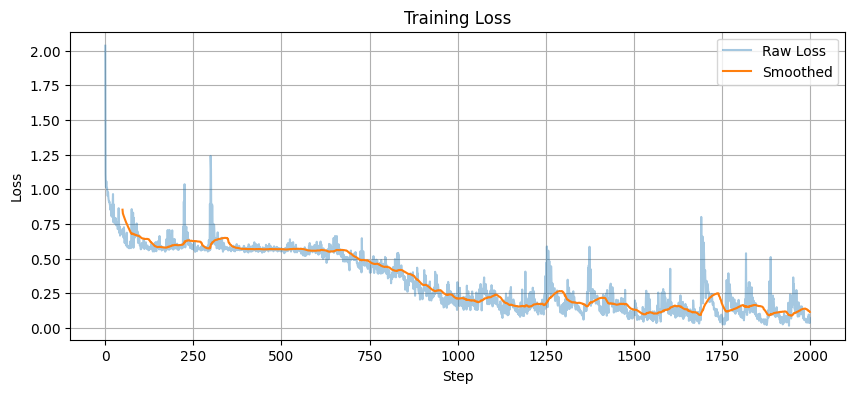

In [192]:
plt.figure(figsize=(10, 4))
plt.plot(loss_history, alpha=0.4, label="Raw Loss")

window = 50
smoothed = np.convolve(loss_history, np.ones(window)/window, mode="valid")
plt.plot(range(window-1, len(loss_history)), smoothed, label="Smoothed")

plt.title("Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Greedy Decode

In [257]:
def greedy_decode(model, src):
    model.eval()
    src_mask = (src != PAD).unsqueeze(1).unsqueeze(2)

    enc = model.pos(model.embed(src))
    for layer in model.encoder:
        enc = layer(enc, src_mask)

    ys = torch.ones(src.size(0), 1).long()

    for _ in range(MAX_LEN):
        tgt_mask = subsequent_mask(ys.size(1))
        out = model(src, ys, src_mask, tgt_mask)
        next_word = out[:, -1].argmax(dim=-1).unsqueeze(1)
        ys = torch.cat([ys, next_word], dim=1)

    return ys

# Example + Attention Heatmap

In [260]:
src, tgt = generate_batch(batch_size=1)
pred = greedy_decode(model, src)

print("\n🔍 Example")
print("SRC :", src[0].tolist())
print("TGT :", tgt[0].tolist())
print("PRED:", pred[0].tolist())


🔍 Example
SRC : [1, 2, 1, 1, 1, 3, 2, 1, 1, 1, 2]
TGT : [2, 2, 1, 1, 2, 4]
PRED: [1, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4]


# Attention visualization

## Decoder self-attention

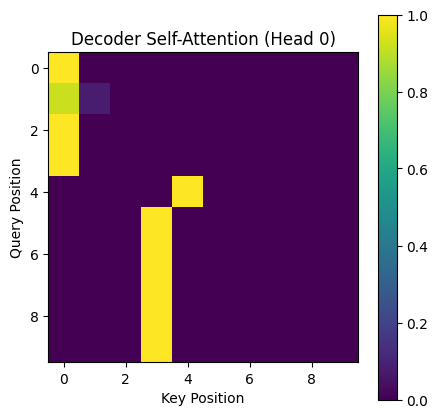

In [264]:
dec_self_attn = model.decoder[-1].self_attn.last_attn[0, 0].cpu().numpy()

plt.figure(figsize=(5, 5))
plt.imshow(dec_self_attn, cmap="viridis")
plt.title("Decoder Self-Attention (Head 0)")
plt.xlabel("Key Position")
plt.ylabel("Query Position")
plt.colorbar()
plt.show()

## Encoder self-attention


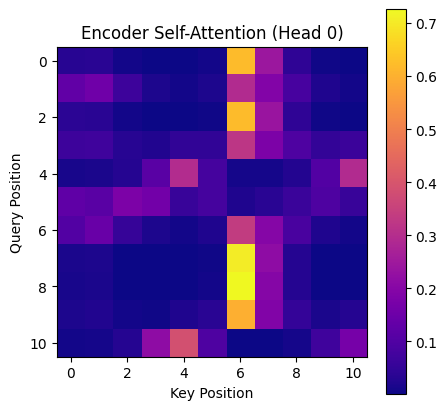

In [267]:
enc_attn = model.encoder[-1].attn.last_attn[0, 0].cpu().numpy()

plt.figure(figsize=(5, 5))
plt.imshow(enc_attn, cmap="plasma")
plt.title("Encoder Self-Attention (Head 0)")
plt.xlabel("Key Position")
plt.ylabel("Query Position")
plt.colorbar()
plt.show()

## Encoder-Decoder attention


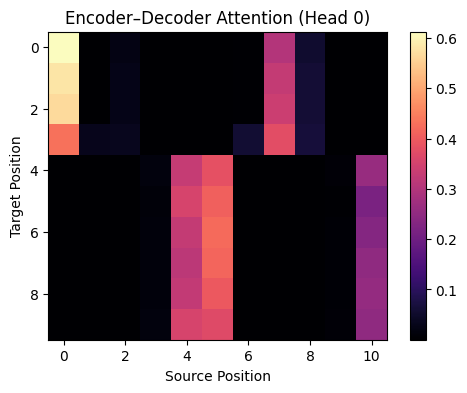

In [270]:
cross_attn = model.decoder[-1].enc_attn.last_attn[0, 0].cpu().numpy()

plt.figure(figsize=(6, 4))
plt.imshow(cross_attn, cmap="magma")
plt.title("Encoder–Decoder Attention (Head 0)")
plt.xlabel("Source Position")
plt.ylabel("Target Position")
plt.colorbar()
plt.show()

# Token-Level Prediction vs Target


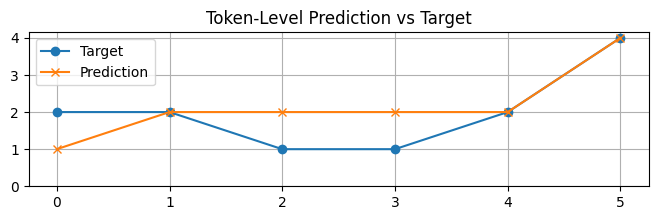

In [273]:
plt.figure(figsize=(8, 2))
plt.plot(tgt[0].tolist(), label="Target", marker="o")
plt.plot(pred[0][:len(tgt[0])].tolist(), label="Prediction", marker="x")
plt.title("Token-Level Prediction vs Target")
plt.yticks(range(VOCAB_SIZE))
plt.legend()
plt.grid()
plt.show()

# Attention Entropy (Sharpness)

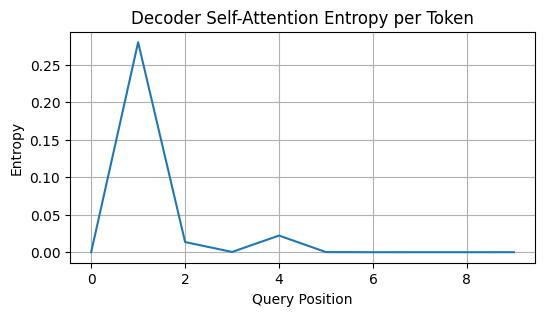

In [276]:
entropy = -(dec_self_attn * np.log(dec_self_attn + 1e-9)).sum(axis=-1)

plt.figure(figsize=(6, 3))
plt.plot(entropy)
plt.title("Decoder Self-Attention Entropy per Token")
plt.xlabel("Query Position")
plt.ylabel("Entropy")
plt.grid()
plt.show()